In [1]:
### Imports
import string
import re
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
pd.set_option("display.max_rows", None)

# Preprocessing of Text for Analysis Purposes

## Import the new dataframe
(that has artist names removed from transcripts)

In [3]:
df = pd.read_json('../raw_data/df_all_clean .json')

In [4]:
len(df)

555

## Cleaning Functions

In [5]:
### Specific functions to our data - Scraps from the Loft and BBC

# remove notes (Bo Burnham Only)
def clean_bo(text):
    txt = text
    for note in '♫♪':
        txt = txt.replace(note, '')
    return txt

def remove_music(text):
    text = re.sub('♪.*?♪', '', text) # remove ♪ stuff that looks like this ♪
    text = re.sub('♫.*?♫', '', text) # remove ♫ stuff that looks like this ♫
    return text

def remove_bracketed(text):
    text = re.sub('\[.*?\]', '', text) # remove [stuff that looks like this]
    text = re.sub('\(.*?\)', '', text) # remove (stuff that looks like this)
    return text

def remove_speaker_tags(text):
    text = re.sub('\s[\w-]+( \w+)?:\s', ' ', text) # remove Word: or Word word: with a newline or space before
    return text

def remove_info(text):
    text = re.sub('subtitle(s)? by .*', '', str(text)) # remove subtile(s) by xxxx
    text = re.sub('(a)? netflix (original )?(comedy )?(special ?)?', '', text) # remove A Netflix Original Comedy Special
    text = re.sub('(this )?(programme )?(contains )?(very |some )?strong language( |\.)', '', text) # remove strong language
    text = re.sub('adult humou?r( |\.?)?', '', text) # remove adult humour
    text = re.sub('(original )?air date', '', text) # remove air date
    return text

In [6]:
# general functions for text pre-processing
def remove_punc(text, chars):
    txt = text
    for punc in chars:
        txt = txt.replace(punc, '')
    return txt

def remove_num(text):
    return ''.join(char for char in text if not char.isdigit())

def remove_stopw(text, word_list):
    word_tokens = word_tokenize(text)
    return ' '.join(w for w in word_tokens if not w in word_list)

def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split(' ') if len(lemmatizer.lemmatize(word))>2)

In [7]:
lemmatizer_dict = {'got': 'get',
                  'gon': 'go',
                  'said': 'say',
                  'fucking': 'fuck',
                  'went': 'go',
                  'finding': 'find'}

def manual_lemmatizer(text):
    for k, v in lemmatizer_dict.items():
        text = text.replace(k, v)
    return text

## Modifying & applying removal lists 

In [8]:
clean_df = df.copy()

### Remove everything in Brackets, Music notes

In [9]:
clean_df['full_transcript_clean'] = clean_df['full_transcript'].apply(remove_bracketed)

In [10]:
### clean Bo before removing music
clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'] = clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'].apply(clean_bo)

/var/folders/s8/jf61hd8n2cj411r4h4mdpyf00000gn/T/ipykernel_82826/3470318112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'] = clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'].apply(clean_bo)


In [11]:
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_music)

### Lowercase, remove useless regex matches
Including specific scraps/BBC format

In [12]:
# lowercase all the words
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].str.lower()

In [13]:
# remove speaker tags and info regexes
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_info)
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_speaker_tags)

### Remove numbers and stopwords + common comedy words, remove punctuation


In [14]:
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_num)

In [15]:
### additional words to remove from the scripts
words_to_remove = ['thank', 'cheering', 'recorded', 'applause', 'laughter', 'laughing', 'murmuring', 'chatter',
                       'aired', 'filmed', 'ladies', 'gentlemen', 'welcome', 'stage', 'transcript', 'netflix']
                    
                    # 'know'? 'go'? 'fuck'?
    
                    # haven't left 'i'm' etc. as those should be cleaned up
                    # by a mixture of stopwords, punctuation removeal, lemmatizing and minimum length

stopwords_plus = words_to_remove + stopwords.words('english')

clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_stopw, args=(stopwords_plus,))

In [16]:
punc_added = string.punctuation + '“”‘’…♪♫¶'

clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(remove_punc, args=(punc_added,))

### Lemmatize

In [17]:
clean_df['full_transcript_clean'] = clean_df['full_transcript_clean'].apply(lemmatize).apply(manual_lemmatizer)

In [18]:
clean_df.head()

,full_transcript,artist,show_name,year,source,full_transcript_clean
0,[rock music playing]\n\n[indistinct chatter]\n...,Adam Devine,Best Time Of Our Lives,2019.0,Scraps from the Loft,hey man let hey everybody right yeah guy much ...
1,"strong language. CHEERING Yes, yes, yes! How...",Adam Hess,Live from the BBC,2016.0,BBC,yes yes yes well hello lovely name going apolo...
2,"Ladies and gentlemen, please welcome your hos...",Adam Hills,Live at the Apollo Series 9 Episode 4,2013.0,BBC,please host tonight hello london hello london ...
3,some strong language and adult humour Ladies...,Adam Hills,Live at the Apollo Series 12 Episode 4,2016.0,BBC,please host tonight hello apollo know hair los...
4,"? CHEERING Hello, Apollo. I am going to start ...",Adam Hills,Live at the Apollo Series 5 Episode 5,2009.0,BBC,hello apollo going start saying something prob...


In [19]:
print(clean_df['full_transcript_clean'].iloc[69][:50])

southern california ready good time tonight get ex


## LDA model to see topics

In [20]:
vectorizer = TfidfVectorizer().fit(clean_df['full_transcript_clean'])
data_vectorized = vectorizer.transform(clean_df['full_transcript_clean'])
lda_model = LatentDirichletAllocation(n_components=3).fit(data_vectorized)

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, vectorizer)

Topic 0:
[('goodnight', 0.33485638421302555), ('maan', 0.3339720417297573), ('noo', 0.3339441675274562), ('nuh', 0.33392820285259206), ('mutter', 0.33389770058264145), ('whine', 0.3338887346426629), ('hnn', 0.33388678918964027), ('acquisition', 0.3338666094554018), ('oof', 0.33386041294411917), ('apollo', 0.333853586012298)]
Topic 1:


/Users/beebo/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('like', 133.1903590789871), ('get', 101.44381817589559), ('know', 81.04527301257134), ('say', 59.93028768677897), ('fuck', 48.860211978332124), ('right', 43.28509819553504), ('one', 41.03219616761848), ('people', 40.21083305830562), ('go', 38.25376220047053), ('going', 30.97247239101376)]
Topic 2:
[('goodnight', 0.33485640175643194), ('maan', 0.33397208576738047), ('noo', 0.33394420787977375), ('nuh', 0.3339282433269649), ('mutter', 0.3338977340548049), ('whine', 0.3338887717109938), ('hnn', 0.33388677525591465), ('acquisition', 0.3338666336786063), ('oof', 0.33386046523046164), ('apollo', 0.33385358516757635)]


## Word frequency

In [21]:
token_df = clean_df['full_transcript_clean'].apply(tokenize).astype(str)
token_df.head(20)

0     ['hey', 'man', 'let', 'hey', 'everybody', 'rig...
1     ['yes', 'yes', 'yes', 'well', 'hello', 'lovely...
2     ['please', 'host', 'tonight', 'hello', 'london...
3     ['please', 'host', 'tonight', 'hello', 'apollo...
4     ['hello', 'apollo', 'going', 'start', 'saying'...
5     ['okay', 'ready', 'and', 'take', 'cue', 'adam'...
6     ['casino', 'liban', 'beirut', 'hello', 'wow', ...
7     ['hello', 'hello', 'apollo', 'well', 'delighte...
8     ['please', 'give', 'warm', 'happening', 'guy',...
9     ['please', 'host', 'tonight', 'pub', 'landlord...
10    ['please', 'host', 'tonight', 'pub', 'landlord...
11    ['hello', 'goodnight', 'wow', 'amazing', 'thea...
12    ['please', 'host', 'tonight', 'live', 'apollo'...
13    ['lady', 'please', 'host', 'tonight', 'lovely'...
14    ['much', 'comedian', 'new', 'york', 'spent', '...
15    ['please', 'hello', 'coming', 'hello', 'hello'...
16    ['please', 'goodness', 'heard', 'rumor', 'asia...
17    ['please', 'host', 'tonight', 'much', 'ind

In [22]:
pd.Series([y for x in token_df.values.flatten() for y in x.split()]).value_counts().head(50)

'like',         47957
'get',          33893
'know',         27551
'say',          19163
'right',        14647
'fuck',         13647
'one',          13051
'go',           12819
'people',       12530
'think',         9580
'thing',         9076
'guy',           8927
'going',         8924
'want',          8819
'time',          8606
'yeah',          8577
'shit',          8491
'would',         7730
'look',          7596
'come',          7518
'man',           7378
'see',           7353
'good',          6693
'back',          6189
'really',        6071
'little',        5889
'cause',         5714
'well',          5502
'make',          5480
'love',          5372
'woman',         5310
'let',           5253
'day',           5222
'never',         5185
'even',          4841
'mean',          4816
'year',          4777
'way',           4758
'take',          4736
'tell',          4695
'kid',           4691
'could',         4622
'put',           4407
'okay',          4353
'ever',          4252
'something

## Bag of words

In [23]:
def dict_bow(df):
    keys = df.sum().index
    values = df.sum().values
    bow_dict = dict(zip(keys, values))
    return bow_dict

In [24]:
# first bow

t = clean_df['full_transcript_clean'].astype(str)

vectorizer = CountVectorizer(min_df = 0.3, max_df = 0.8, ngram_range=(1,1))
X = vectorizer.fit_transform(t)
bow_df1 = pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names())
len(bow_df1.columns)

/Users/beebo/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


601

In [25]:
dict_1 = dict_bow(bow_df1)

In [32]:
# second bow

t = clean_df['full_transcript_clean'].astype(str)

vectorizer = CountVectorizer(min_df = 0.4, max_df = 0.8, ngram_range=(1,1))
X = vectorizer.fit_transform(t)
bow_df2 = pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names())

dict_2 = dict_bow(bow_df2)

/Users/beebo/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
# third bow

t = clean_df['full_transcript_clean'].astype(str)

vectorizer = CountVectorizer(min_df = 0.4, max_df = 0.8, max_features=50, ngram_range=(1,2))
X = vectorizer.fit_transform(t)
bow_df3 = pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names())

dict_3 = dict_bow(bow_df3)

/Users/beebo/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Word cloud with frequencies

In [30]:
def make_word_cloud(wc, bow_dict):
    word_cloud = wc.generate_from_frequencies(bow_dict)
    return word_cloud

In [26]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [47]:
import numpy as np
from PIL import Image
mask = np.array(Image.open('../raw_data/microphone.png'))


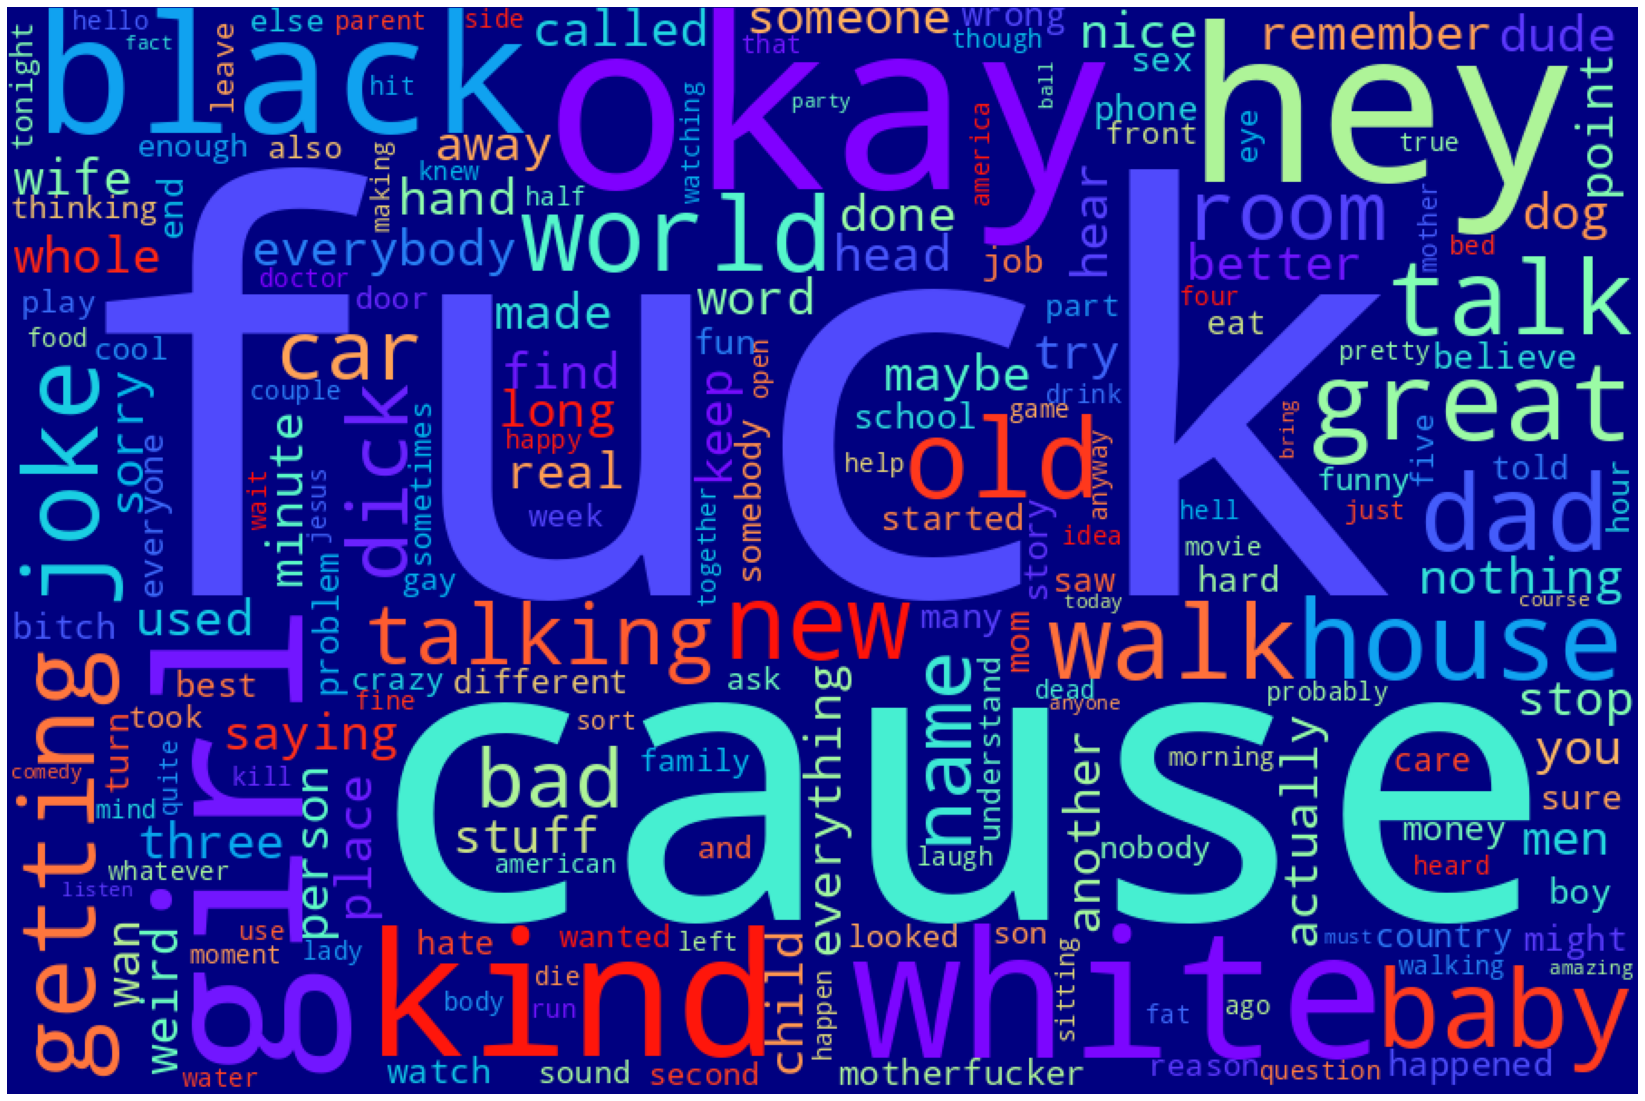

In [56]:
wc = WordCloud(width=3000, height = 2000, background_color='navy', colormap='rainbow',
                       random_state=1, collocations=False, stopwords = STOPWORDS, mask=mask)
word_cloud = make_word_cloud(wc, dict_1)
plot_cloud(word_cloud)

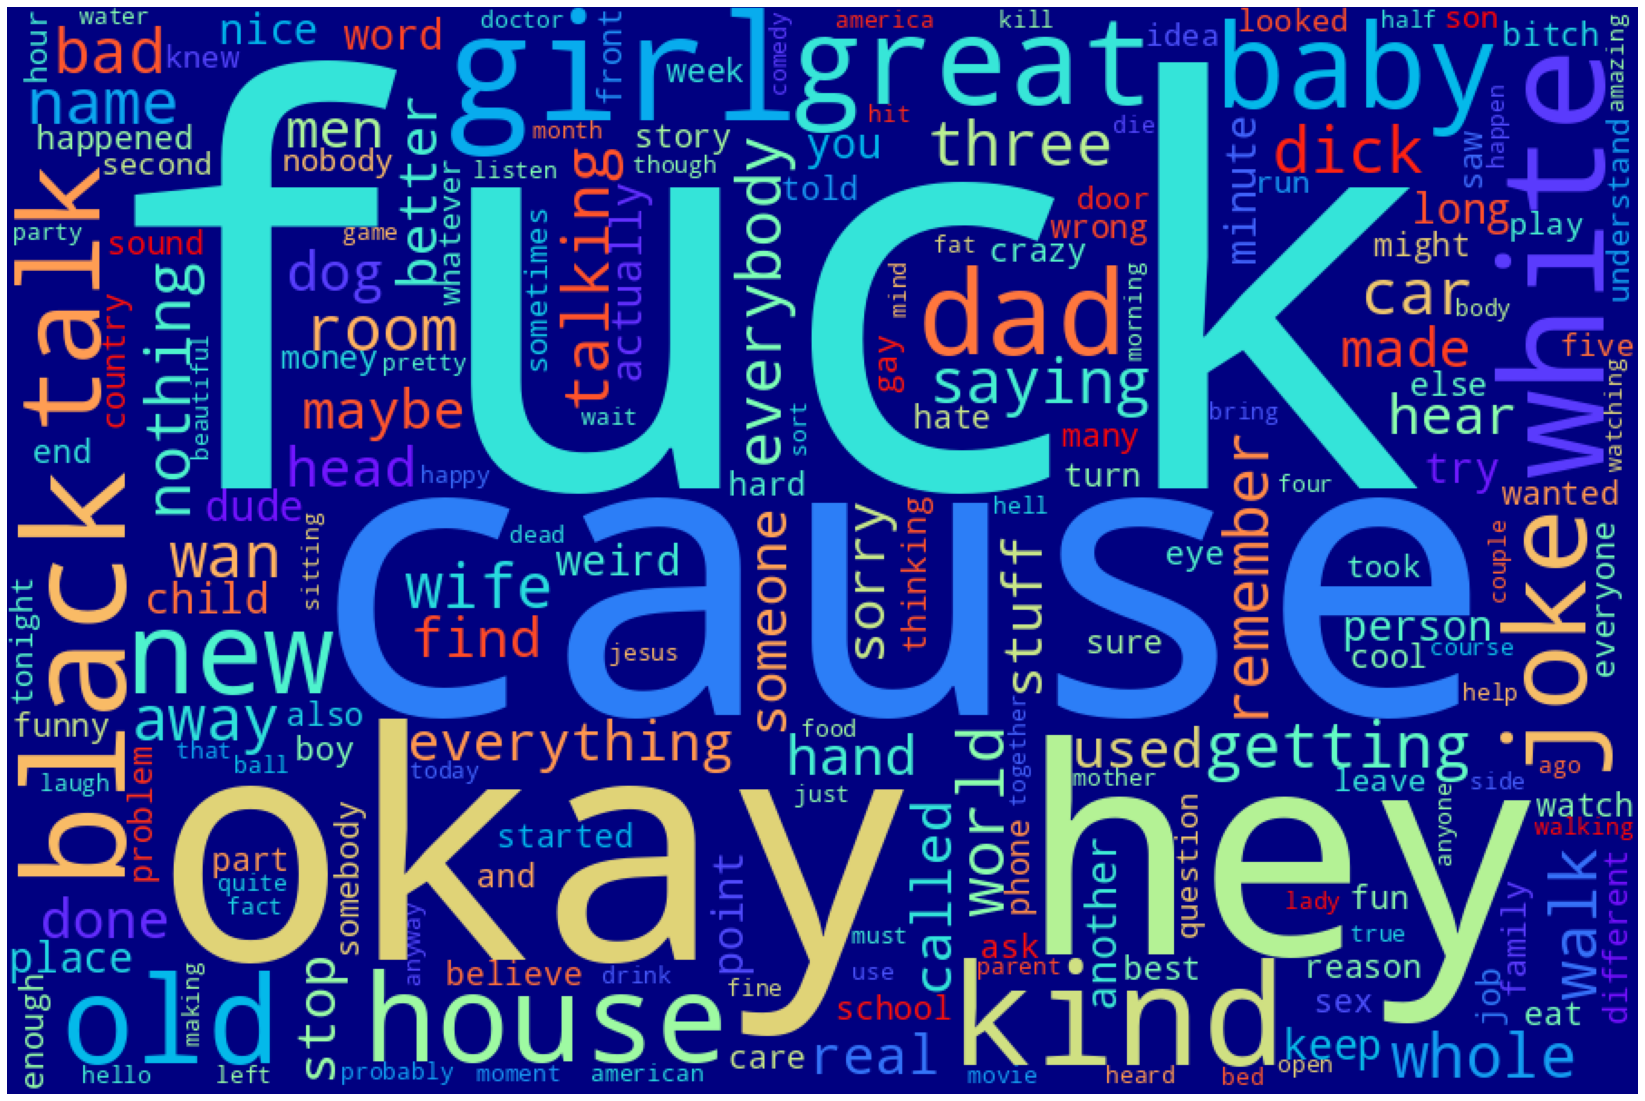

In [49]:
word_cloud = make_word_cloud(wc, dict_2)
plot_cloud(word_cloud)

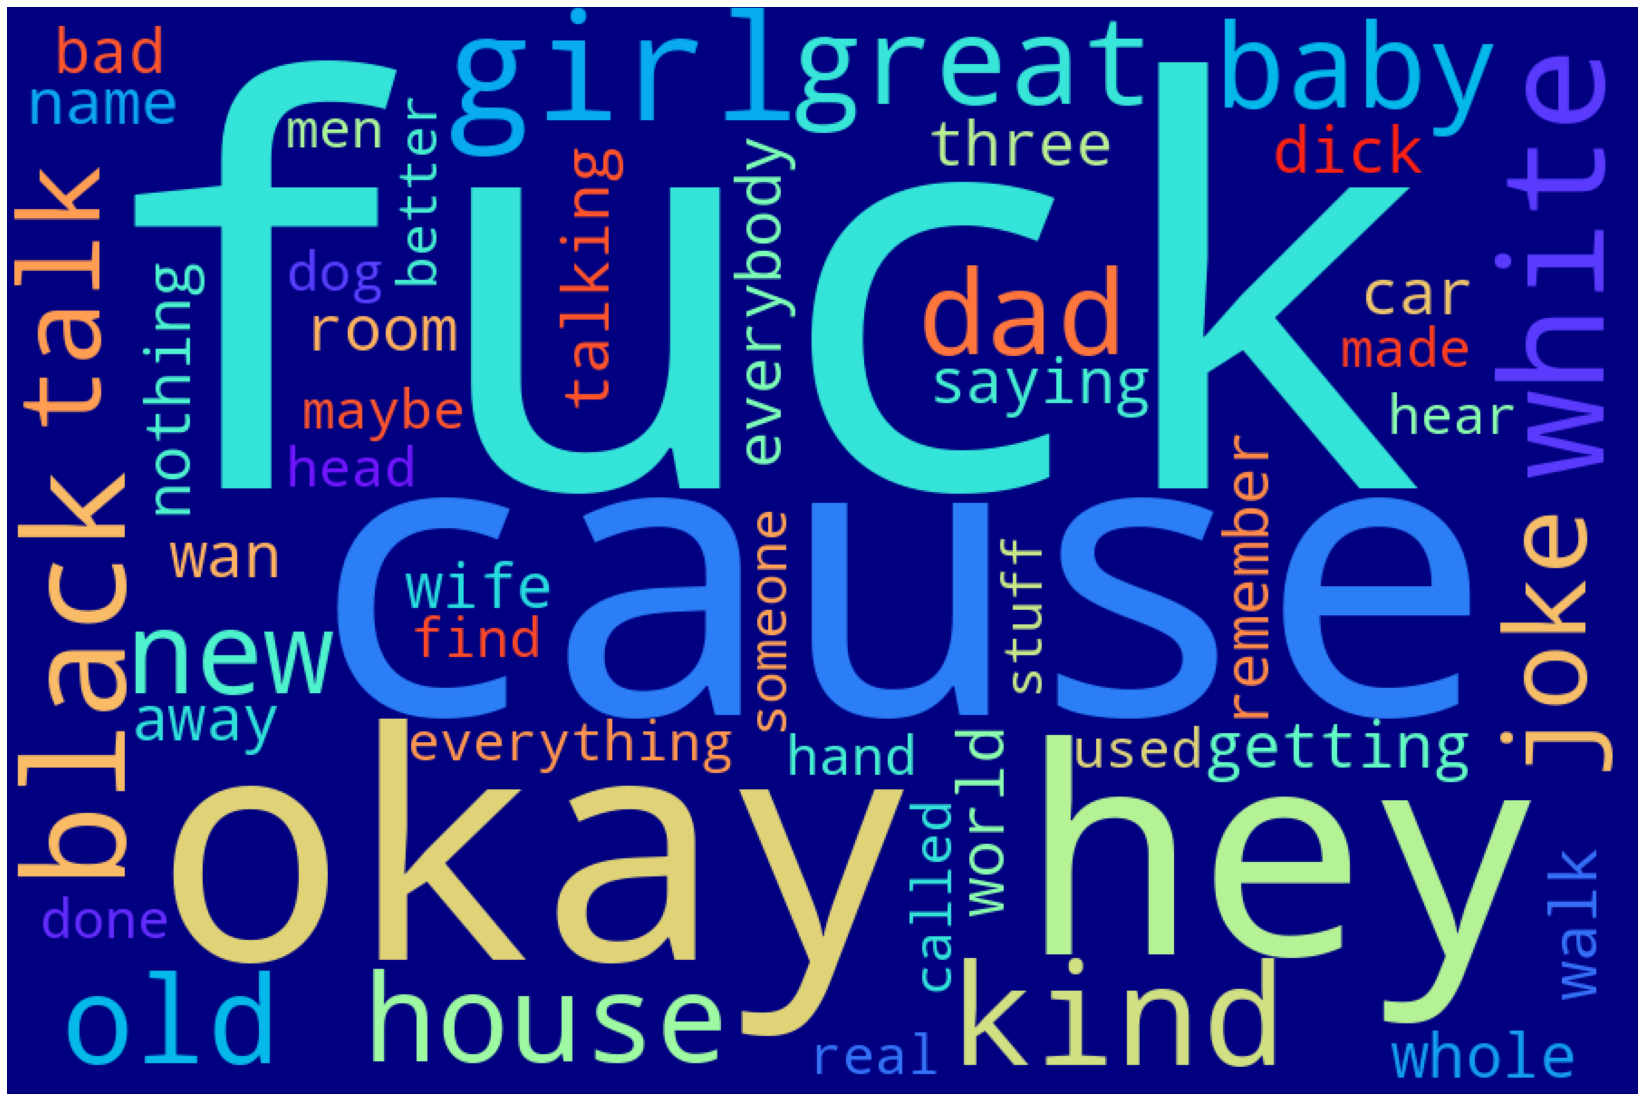

In [57]:
word_cloud = make_word_cloud(wc, dict_3)
plot_cloud(word_cloud)

# ----- **note to self: start from here**-----

In [ ]:
full_transcripts = ' '.join(clean_df['full_transcript_clean'])

In [ ]:
len(full_transcripts)

In [ ]:
word_cloud = WordCloud(width=3000, height = 2000,
                       random_state=1, colormap='Pastel1',
                       collocations=False, stopwords = STOPWORDS).generate(full_transcripts)

In [ ]:
plot_cloud(word_cloud)